In [1]:
import pandas as pd
import numpy as np
np.random.seed(seed=42)
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

Loading Data

In [2]:
df = pd.read_csv('D_Train1.csv')
X = df.drop(columns = ['Location'])
y = df['Location']

Splitting Data (testing out without feature engineering first)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.1, random_state = 0,stratify=y)

In [4]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_train.shape

(1440, 7)

In [5]:
def plot_conf(c_mat):
  plt.figure()
  ax = sns.heatmap(c_mat,annot=True,fmt='d',cmap="Reds")
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')

def eval(model, X_train, y_train, X_val, y_val, X, y):
  print("Training Accuracy:", model.score(X_train, y_train))
  print("Validation Set Accuracy:", model.score(X_val, y_val))
  cross_val = cross_val_score(model, x_scaler.transform(X), y, cv=5)
  print("Mean Cross-Validation Accuracy:", np.mean(cross_val))
  print("Standard deviation:", np.std(cross_val))
  y_pred = model.predict(X_val)
  plot_conf(confusion_matrix(y_val,y_pred))

ML Models

In [6]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

Training Accuracy: 0.9840277777777777
Validation Set Accuracy: 0.99375
Mean Cross-Validation Accuracy: 0.9843750000000002
Standard deviation: 0.005229125165837968


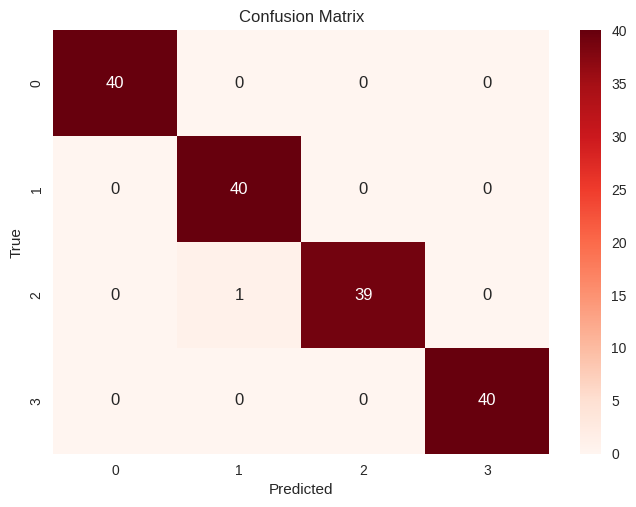

In [7]:
eval(nb, X_train, y_train, X_val, y_val, X, y)

In [8]:
c = [0.001,0.01, 0.1, 1, 10, 50, 100, 200]
param_grid = {'C':c}

grid_search = GridSearchCV(LogisticRegression(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameter:", grid_result.best_params_)

lr = LogisticRegression(C = grid_result.best_params_['C'], penalty = 'l2',
                        solver='lbfgs',multi_class='multinomial')
lr.fit(X_train,y_train)

The best parameter: {'C': 10}


LogisticRegression(C=10, multi_class='multinomial')

Training Accuracy: 0.9840277777777777
Validation Set Accuracy: 0.99375
Mean Cross-Validation Accuracy: 0.9806250000000001
Standard deviation: 0.008705242673240066


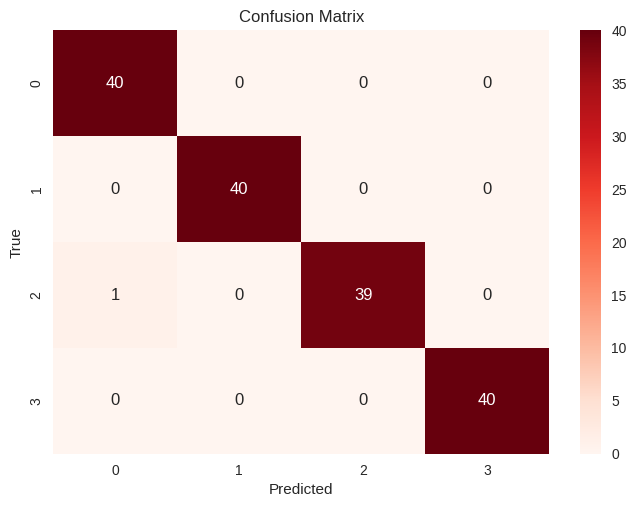

In [9]:
eval(lr, X_train, y_train, X_val, y_val, X, y)

In [10]:
#SVM classifier
c = [0.01, 0.1, 1, 10, 50, 100, 200]
gamma = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'C':c, 'gamma':gamma}

grid_search = GridSearchCV(SVC(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameters:", grid_result.best_params_)

svc = SVC(kernel = 'rbf', C = grid_result.best_params_['C'],
          gamma = grid_result.best_params_['gamma'], probability=True)
svc.fit(X_train,y_train)

The best parameters: {'C': 200, 'gamma': 0.01}


SVC(C=200, gamma=0.01, probability=True)

Training Accuracy: 0.9881944444444445
Validation Set Accuracy: 0.99375
Mean Cross-Validation Accuracy: 0.984375
Standard deviation: 0.007905694150420963


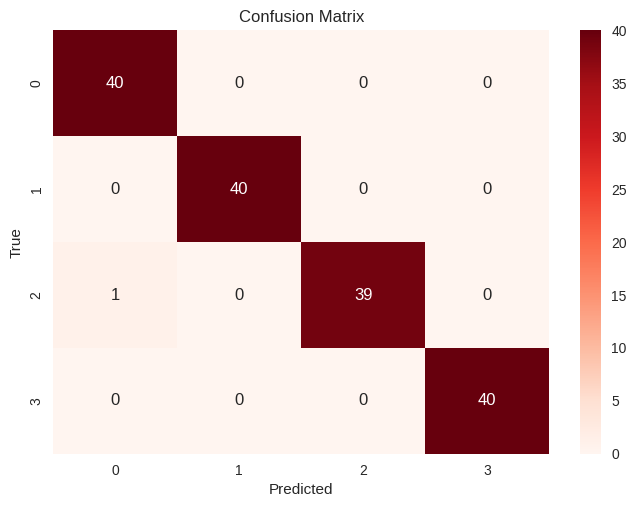

In [11]:
eval(svc, X_train, y_train, X_val, y_val, X, y)

In [12]:
#XGBoost Classififer
rates = [0.01,0.05,0.1,0.15,0.2]
n = [10, 50, 100, 200]
depth_values = range(1,20,1)
y_train_xgb = np.array(y_train) - 1
param_grid  = {'learning_rate':rates,'n_estimators':n, 'max_depth':depth_values, 'random_state':[0]}

grid_search = GridSearchCV(XGBClassifier(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train_xgb)

print("The best parameters:",grid_result.best_params_)
xgb = XGBClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                learning_rate = grid_result.best_params_['learning_rate'],
                                max_depth = grid_result.best_params_['max_depth'],
                                objective='multi:softmax', n_jobs = -1, random_state=0)

xgb.fit(X_train,y_train_xgb)

The best parameters: {'learning_rate': 0.15, 'max_depth': 11, 'n_estimators': 200, 'random_state': 0}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softmax', ...)

Training Accuracy: 1.0
Validation Set Accuracy: 1.0
Mean Cross-Validation Accuracy: 0.98125
Standard deviation: 0.003423265984407296


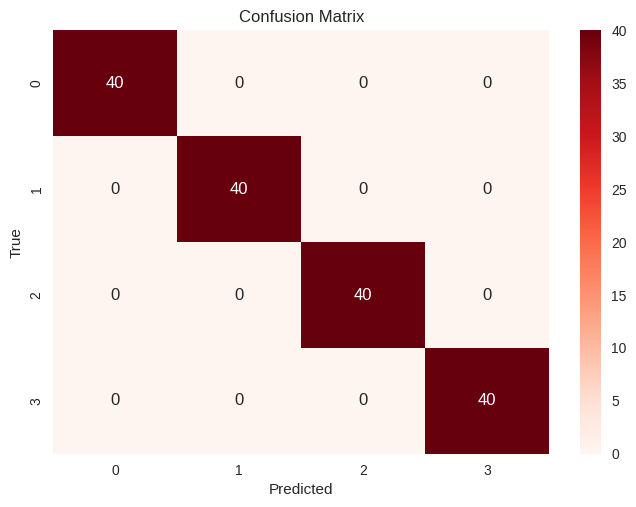

In [13]:
y_val_xgb = np.array(y_val) - 1
y_xgb = np.array(y) - 1
eval(xgb, X_train, y_train_xgb, X_val, y_val_xgb, X, y_xgb)

In [14]:
#KNN Classifier
k = list(range(1,11))
weights = ['uniform','distance']

param_grid = {'n_neighbors':k,'weights': weights}
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameters:", grid_result.best_params_)

knn = KNeighborsClassifier(n_neighbors = grid_result.best_params_['n_neighbors'],
                           weights = grid_result.best_params_['weights'], n_jobs = -1)
knn.fit(X_train,y_train)

The best parameters: {'n_neighbors': 7, 'weights': 'distance'}


KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')

Training Accuracy: 1.0
Validation Set Accuracy: 0.99375
Mean Cross-Validation Accuracy: 0.9831249999999999
Standard deviation: 0.008291561975888512


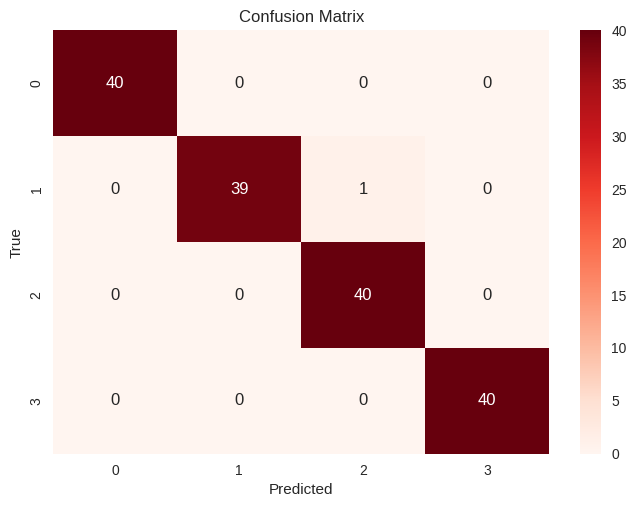

In [15]:
eval(knn, X_train, y_train, X_val, y_val, X, y)

In [16]:
#Random Forest Classifier
max_depth = list(range(1,20,1))
n = [10, 50, 100, 200]

param_grid = {'max_depth':max_depth,'n_estimators':n,'random_state':[0]}
grid_search = GridSearchCV(RandomForestClassifier(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameters:",grid_result.best_params_)

rf = RandomForestClassifier(n_estimators = grid_result.best_params_['n_estimators'],
                            max_depth = grid_result.best_params_['max_depth'],
                            n_jobs = -1, random_state=0)
rf.fit(X_train,y_train)

The best parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 0}


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=0)

Training Accuracy: 0.9965277777777778
Validation Set Accuracy: 1.0
Mean Cross-Validation Accuracy: 0.9825000000000002
Standard deviation: 0.0037500000000000016


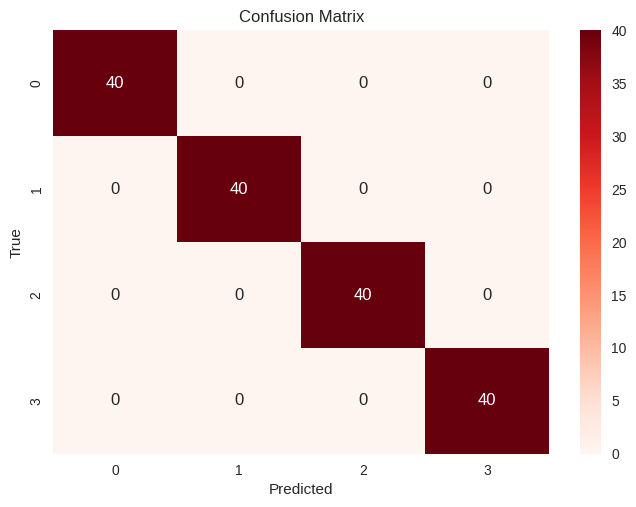

In [17]:
eval(rf, X_train, y_train, X_val, y_val, X, y)

In [18]:
#MLP Classifier
alpha = 10.0 ** -np.arange(1, 10)
max_iter = [800,1000,1500]

param_grid = {'alpha':alpha,'max_iter':max_iter,'random_state':[0]}
grid_search = GridSearchCV(MLPClassifier(),param_grid,cv=5)                   #Citation - scikit-learn.org sklearn API reference documentation
grid_result = grid_search.fit(X_train,y_train)

print("The best parameters:",grid_result.best_params_)

mlp = MLPClassifier(alpha = grid_result.best_params_['alpha'],                    #Citation - scikit-learn.org sklearn API reference documentation
                    max_iter = grid_result.best_params_['max_iter'],random_state=0)
mlp.fit(X_train,y_train)

The best parameters: {'alpha': 0.1, 'max_iter': 800, 'random_state': 0}


MLPClassifier(alpha=0.1, max_iter=800, random_state=0)

Training Accuracy: 0.9888888888888889
Validation Set Accuracy: 0.99375
Mean Cross-Validation Accuracy: 0.98375
Standard deviation: 0.008705242673240072


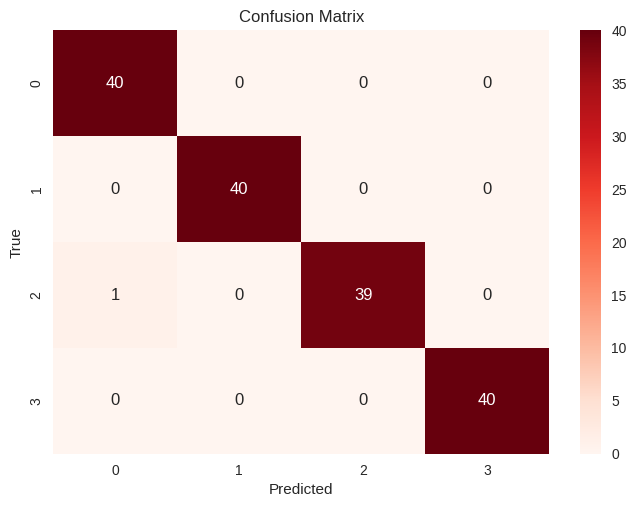

In [19]:
eval(mlp, X_train, y_train, X_val, y_val, X, y)

Testing the best performing model on Test Data

In [20]:
df_test = pd.read_csv('D_Test1.csv')
X_test = df_test.drop(columns = ['Location'])
y_test = df_test['Location']

In [21]:
X_test = x_scaler.transform(X_test)

Test Accuracy: 0.9775


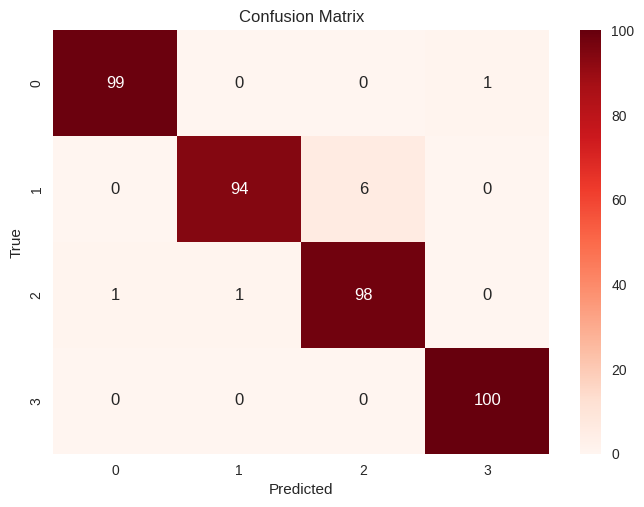

In [22]:
print("Test Accuracy:" , knn.score(X_test,y_test))
y_pred = knn.predict(X_test)
plot_conf(confusion_matrix(y_test, y_pred))

Feature Engineering

In [23]:
def get_features(X):
    for key in X.columns:
        X[key] = 10 ** (X[key]/20)
    X['mean'] = X.mean(axis=1)
    X['std'] = X.std(axis=1)
    for key in X.columns:
        X[key] = 20*(np.log10(X[key]))
    for key in X.columns:
        if key not in ['mean', 'std']:
            X[key+'_scaled'] = (X[key] - X['mean']) / X['std']
    X['Max_WS'] = X[['WS1', 'WS2', 'WS3', 'WS4', 'WS5', 'WS6', 'WS7']].idxmax(axis = 1)
    X['Min_WS'] = X[['WS1', 'WS2', 'WS3', 'WS4', 'WS5', 'WS6', 'WS7']].idxmin(axis=1)
    X['Min_Max'] = X['Max_WS'] + X['Min_WS']
    max_ws_df = X.groupby('Max_WS').mean().reset_index()
    X = X.merge(max_ws_df, on = 'Max_WS', suffixes=('', '_max_ws'), how = 'left')
    for key in X.columns:
        if '_max_ws' in key:
            X[key+'_dist'] = np.fabs(X[key] - X[key[:-len('_max_ws')]])
    min_ws_df = X.groupby('Min_WS').mean().reset_index()
    X = X.merge(min_ws_df, on = 'Min_WS', suffixes=('', '_min_ws'), how = 'left')
    for key in X.columns:
        if '_min_ws' in key:
            X[key+'_dist'] = np.fabs(X[key] - X[key[:-len('_min_ws')]])
    min_ws_df = X.groupby('Min_Max').mean().reset_index()
    X = X.merge(min_ws_df, on = 'Min_Max', suffixes=('', '_min_max'), how = 'left')
    for key in X.columns:
        if '_min_max' in key:
            X[key+'_dist'] = np.fabs(X[key] - X[key[:-len('_min_max')]])
    return pd.get_dummies(X)

In [24]:
X = get_features(X)
X.shape

(1600, 452)

In [25]:
X.fillna(0, inplace=True)

In [26]:
estimator = RandomForestClassifier()
selector = RFE(estimator, verbose = 0, n_features_to_select = 40)

In [27]:
selector.fit(X, y)

RFE(estimator=RandomForestClassifier(), n_features_to_select=40)

In [28]:
selected = [X.columns[i] for i in selector.get_support(indices=True)]
selected

['WS1',
 'WS3',
 'WS4',
 'WS5',
 'WS6',
 'mean',
 'std',
 'WS1_scaled',
 'WS2_scaled',
 'WS3_scaled',
 'WS4_scaled',
 'WS5_scaled',
 'WS6_scaled',
 'WS7_scaled',
 'WS1_min_ws_dist',
 'WS4_min_ws_dist',
 'WS5_min_ws_dist',
 'mean_min_ws_dist',
 'std_min_ws_dist',
 'WS1_scaled_min_ws_dist',
 'WS2_scaled_min_ws_dist',
 'WS5_scaled_min_ws_dist',
 'WS6_scaled_min_ws_dist',
 'WS7_scaled_min_ws_dist',
 'WS5_max_ws_min_ws_dist',
 'mean_min_max',
 'std_min_max',
 'WS1_scaled_min_max',
 'WS2_scaled_min_max',
 'WS4_scaled_min_max',
 'WS5_scaled_min_max',
 'WS7_scaled_max_ws_min_max',
 'WS1_max_ws_dist_min_max',
 'mean_max_ws_dist_min_max',
 'std_max_ws_dist_min_max',
 'WS2_max_ws_min_ws_dist_min_max',
 'WS7_max_ws_dist_min_ws_dist_min_max',
 'WS1_min_max_dist',
 'WS3_scaled_max_ws_dist_min_max_dist',
 'WS5_scaled_max_ws_dist_min_max_dist']

In [29]:
X = X[selected]

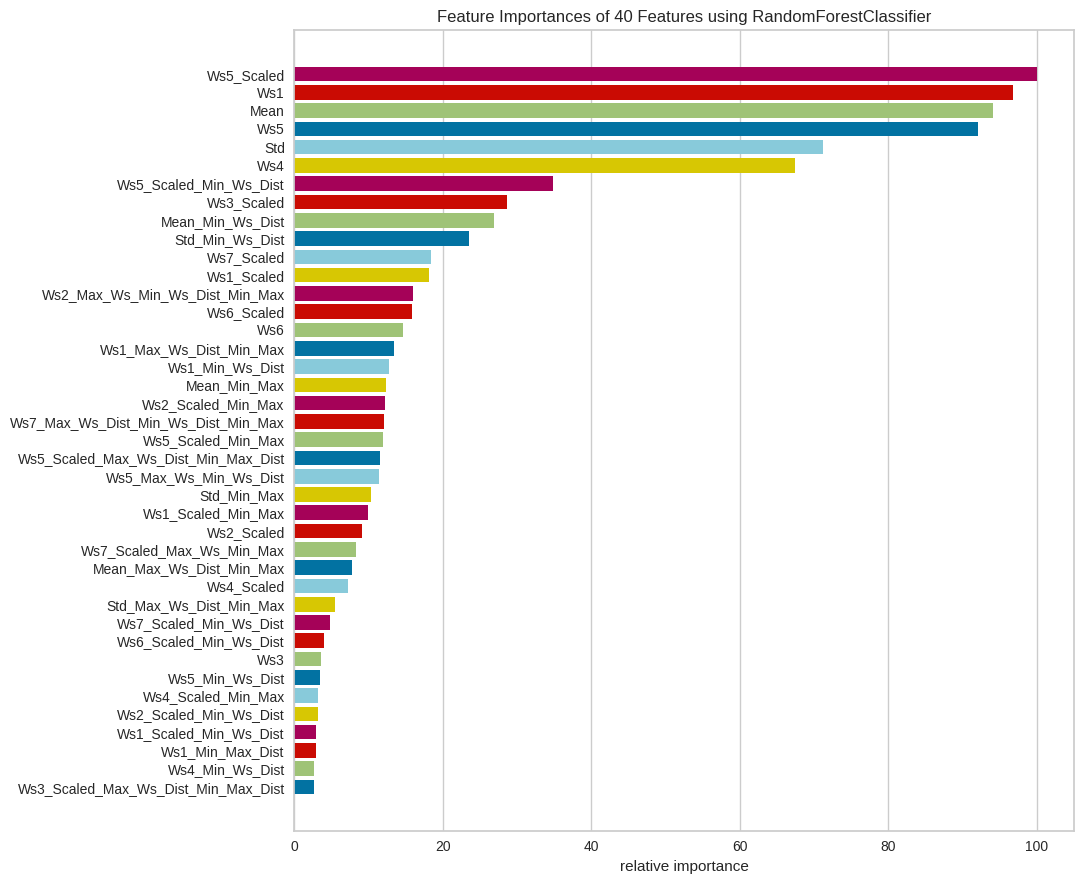

<Axes: title={'center': 'Feature Importances of 40 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [30]:
plt.figure(figsize=(11,9))
ax = plt.gca()

model = RandomForestClassifier(n_jobs = -1)
labels = list(map(lambda s: s.title(), X.columns))
viz = FeatureImportances(model, labels=labels)

viz.fit(X, y)
viz.show(ax=ax)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.1, random_state = 0,stratify=y)

In [32]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_train.shape

(1440, 40)

In [33]:
def plot_conf(c_mat):
  plt.figure()
  ax = sns.heatmap(c_mat,annot=True,fmt='d',cmap="Reds")
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')

def eval(model, X_train, y_train, X_val, y_val, X, y):
  print("Training Accuracy:", model.score(X_train, y_train))
  print("Validation Set Accuracy:", model.score(X_val, y_val))
  cross_val = cross_val_score(model, x_scaler.transform(X), y, cv=5)
  print("Mean Cross-Validation Accuracy:", np.mean(cross_val))
  print("Standard deviation:", np.std(cross_val))
  y_pred = model.predict(X_val)
  plot_conf(confusion_matrix(y_val,y_pred))

In [34]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

Training Accuracy: 0.9701388888888889
Validation Set Accuracy: 0.96875
Mean Cross-Validation Accuracy: 0.96875
Standard deviation: 0.008838834764831853


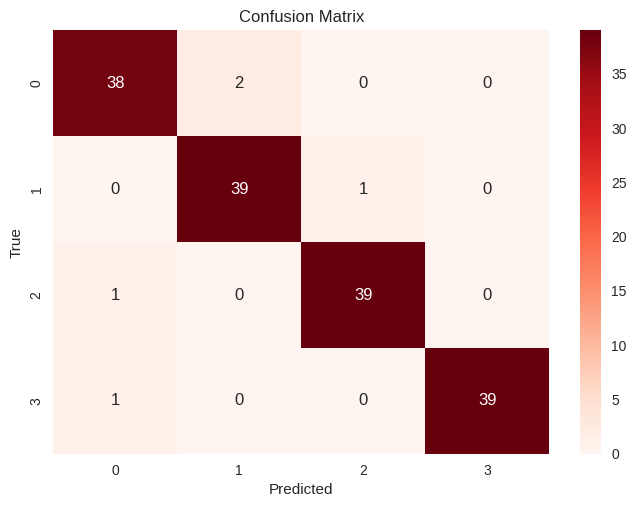

In [35]:
eval(nb, X_train, y_train, X_val, y_val, X, y)

In [36]:
#Logistic Regression classifier.
c = [0.001,0.01, 0.1, 1, 10, 50, 100, 200]
param_grid = {'C':c}

grid_search = GridSearchCV(LogisticRegression(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameter:", grid_result.best_params_)

lr = LogisticRegression(C = grid_result.best_params_['C'], penalty = 'l2',
                        solver='lbfgs',multi_class='multinomial', n_jobs = -1)
lr.fit(X_train,y_train)

The best parameter: {'C': 1}


LogisticRegression(C=1, multi_class='multinomial', n_jobs=-1)

Training Accuracy: 0.9854166666666667
Validation Set Accuracy: 1.0
Mean Cross-Validation Accuracy: 0.9824999999999999
Standard deviation: 0.008052561704203208


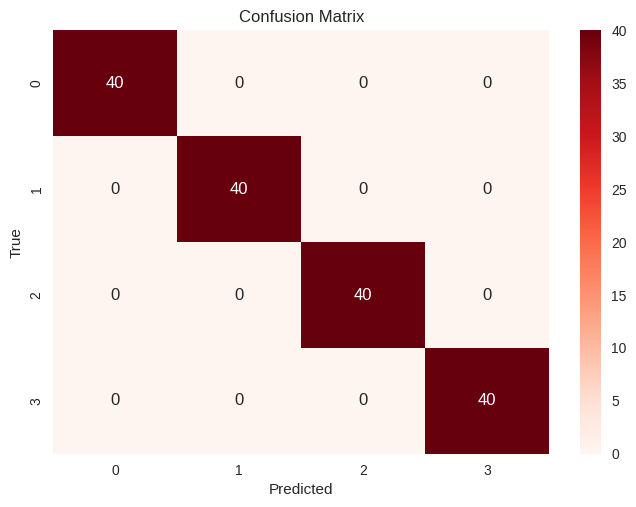

In [37]:
eval(lr, X_train, y_train, X_val, y_val, X, y)

In [38]:
#SVM classifier
c = [0.01, 0.1, 1, 10, 50, 100, 200]
gamma = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'C':c, 'gamma':gamma}

grid_search = GridSearchCV(SVC(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameters:", grid_result.best_params_)

svc = SVC(kernel = 'rbf', C = grid_result.best_params_['C'],
          gamma = grid_result.best_params_['gamma'], probability=True)
svc.fit(X_train,y_train)

The best parameters: {'C': 10, 'gamma': 0.1}


SVC(C=10, gamma=0.1, probability=True)

Training Accuracy: 0.9944444444444445
Validation Set Accuracy: 1.0
Mean Cross-Validation Accuracy: 0.98375
Standard deviation: 0.005376453291901654


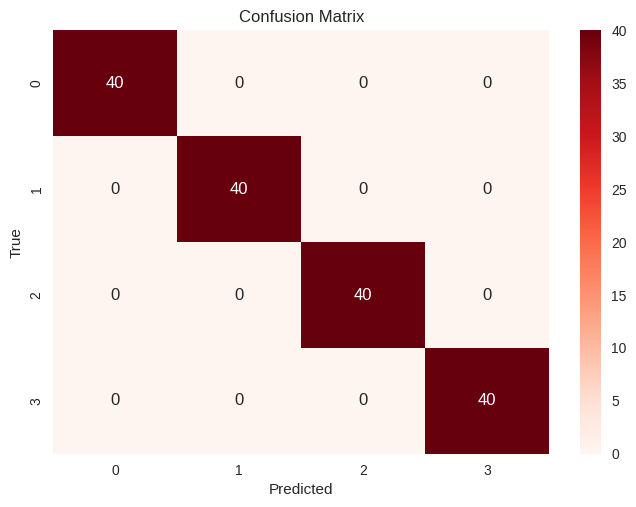

In [39]:
eval(svc, X_train, y_train, X_val, y_val, X, y)

In [40]:
#XGB Classififer
rates = [0.01,0.05,0.1,0.15,0.2]
n = [10, 50, 100, 200]
depth_values = range(1,20,1)

param_grid  = {'learning_rate':rates,'n_estimators':n, 'max_depth':depth_values, 'random_state':[0]}
y_train_xgb = np.array(y_train) - 1
grid_search = GridSearchCV(XGBClassifier(),param_grid,cv=5)
grid_result = grid_search.fit(X_train,y_train_xgb)

print("The best parameters:",grid_result.best_params_)
xgb = XGBClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                learning_rate = grid_result.best_params_['learning_rate'],
                                max_depth = grid_result.best_params_['max_depth'],
                                objective='multi:softmax', n_jobs = -1, random_state=0)

xgb.fit(X_train,y_train_xgb)

The best parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200, 'random_state': 0}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softmax', ...)

Training Accuracy: 0.9944444444444445
Validation Set Accuracy: 0.99375
Mean Cross-Validation Accuracy: 0.983125
Standard deviation: 0.005077524002897479


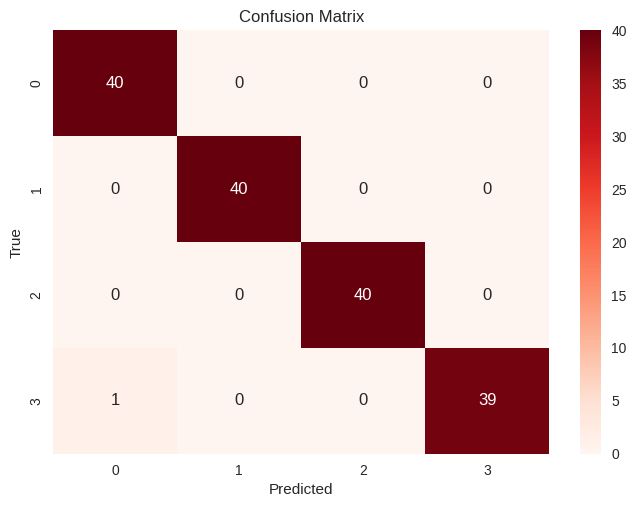

In [41]:
y_val_xgb = np.array(y_val) - 1
y_xgb = np.array(y) - 1
eval(xgb, X_train, y_train_xgb, X_val, y_val_xgb, X, y_xgb)

In [42]:
#KNN Classifier
k = list(range(1,11))
weights = ['uniform','distance']

param_grid = {'n_neighbors':k,'weights': weights}
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameters:", grid_result.best_params_)

knn = KNeighborsClassifier(n_neighbors = grid_result.best_params_['n_neighbors'],
                           weights = grid_result.best_params_['weights'], n_jobs = -1)
knn.fit(X_train,y_train)

The best parameters: {'n_neighbors': 4, 'weights': 'uniform'}


KNeighborsClassifier(n_jobs=-1, n_neighbors=4)

Training Accuracy: 0.9888888888888889
Validation Set Accuracy: 0.9875
Mean Cross-Validation Accuracy: 0.98125
Standard deviation: 0.007126096406869607


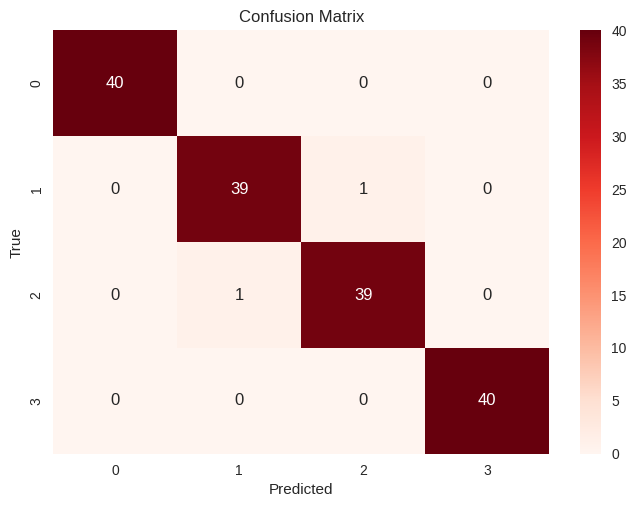

In [43]:
eval(knn, X_train, y_train, X_val, y_val, X, y)

In [44]:
#Random Forest Classifier
max_depth = list(range(1,20,1))
n = [10, 50, 100, 200]

param_grid = {'max_depth':max_depth,'n_estimators':n,'random_state':[0]}
grid_search = GridSearchCV(RandomForestClassifier(),param_grid,cv=5,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameters:",grid_result.best_params_)

rf = RandomForestClassifier(n_estimators = grid_result.best_params_['n_estimators'],
                            max_depth = grid_result.best_params_['max_depth'],
                            n_jobs = -1, random_state=0)
rf.fit(X_train,y_train)

The best parameters: {'max_depth': 6, 'n_estimators': 100, 'random_state': 0}


RandomForestClassifier(max_depth=6, n_jobs=-1, random_state=0)

Training Accuracy: 0.9916666666666667
Validation Set Accuracy: 0.98125
Mean Cross-Validation Accuracy: 0.9806249999999999
Standard deviation: 0.007499999999999999


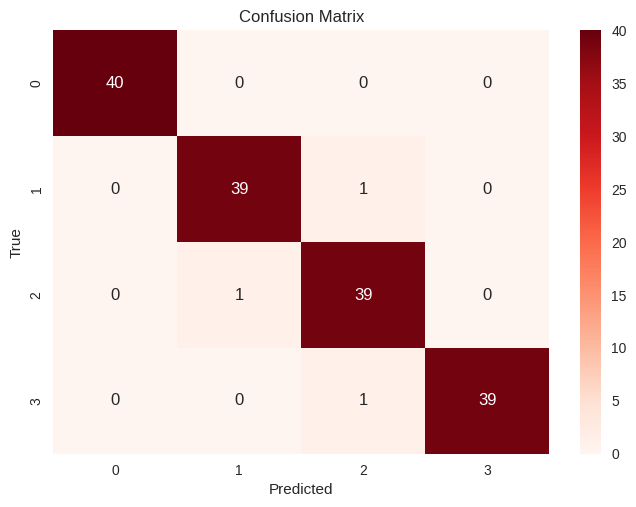

In [45]:
eval(rf, X_train, y_train, X_val, y_val, X, y)

In [46]:
#MLP Classifier
alpha = 10.0 ** -np.arange(1, 10)
max_iter = [800,1000,1500]

param_grid = {'alpha':alpha,'max_iter':max_iter,'random_state':[0]}
grid_search = GridSearchCV(MLPClassifier(),param_grid,cv=5)
grid_result = grid_search.fit(X_train,y_train)

print("The best parameters:",grid_result.best_params_)

mlp = MLPClassifier(alpha = grid_result.best_params_['alpha'],
                    max_iter = grid_result.best_params_['max_iter'],random_state=0)
mlp.fit(X_train,y_train)

The best parameters: {'alpha': 1e-07, 'max_iter': 800, 'random_state': 0}


MLPClassifier(alpha=1e-07, max_iter=800, random_state=0)

Training Accuracy: 0.9916666666666667
Validation Set Accuracy: 0.98125
Mean Cross-Validation Accuracy: 0.9806249999999999
Standard deviation: 0.007499999999999999


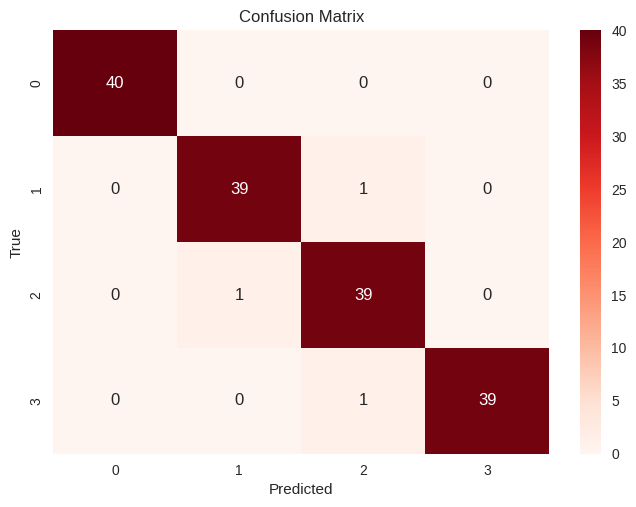

In [47]:
eval(rf, X_train, y_train, X_val, y_val, X, y)

Testing on Test Dataset

In [48]:
df_test = pd.read_csv('D_Test1.csv')
X_test = df_test.drop(columns = ['Location'])
y_test = df_test['Location']
X_test = get_features(X_test)

In [49]:
X_test = x_scaler.transform(X_test[selected])

Test Accuracy: 0.9775


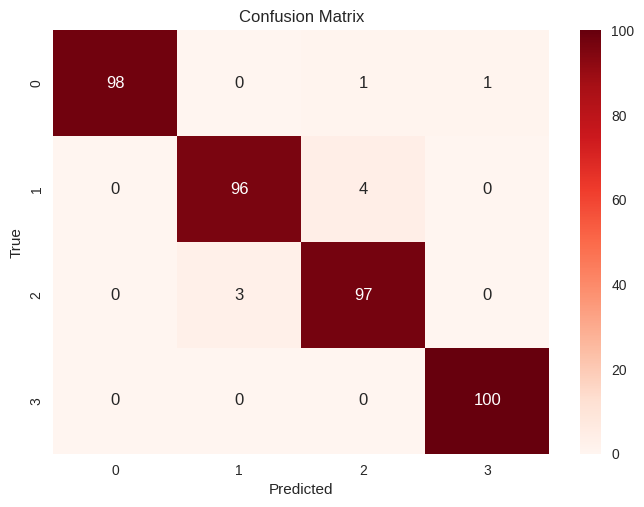

In [50]:
print("Test Accuracy:" , mlp.score(X_test,y_test))
y_pred = mlp.predict(X_test)
plot_conf(confusion_matrix(y_test, y_pred))